<a href="https://colab.research.google.com/github/PranitaAnnaldas/A-predictive-model-to-assess-the-environmental-impact-of-urban-expansion/blob/master/ml/Air_Pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Training models for PM2.5 ===
Random Forest        Average R2: 0.82
Gradient Boosting    Average R2: 0.84
XGBoost              Average R2: 0.85
LightGBM             Average R2: 0.51

Best model for PM2.5: XGBoost (R2: 0.85)

=== Training models for PM10 ===
Random Forest        Average R2: 0.81
Gradient Boosting    Average R2: 0.84
XGBoost              Average R2: 0.84
LightGBM             Average R2: 0.49

Best model for PM10: XGBoost (R2: 0.84)

=== Training models for NO2 ===
Random Forest        Average R2: 0.62
Gradient Boosting    Average R2: 0.73
XGBoost              Average R2: 0.71
LightGBM             Average R2: -0.39

Best model for NO2: Gradient Boosting (R2: 0.73)

=== Training models for SO2 ===
Random Forest        Average R2: 0.81
Gradient Boosting    Average R2: 0.85
XGBoost              Average R2: 0.85
LightGBM             Average R2: 0.50

Best model for SO2: Gradient Boosting (R2: 0.85)

=== Training models for O3 ===
Random Forest        Average R2: 0.75
Gra

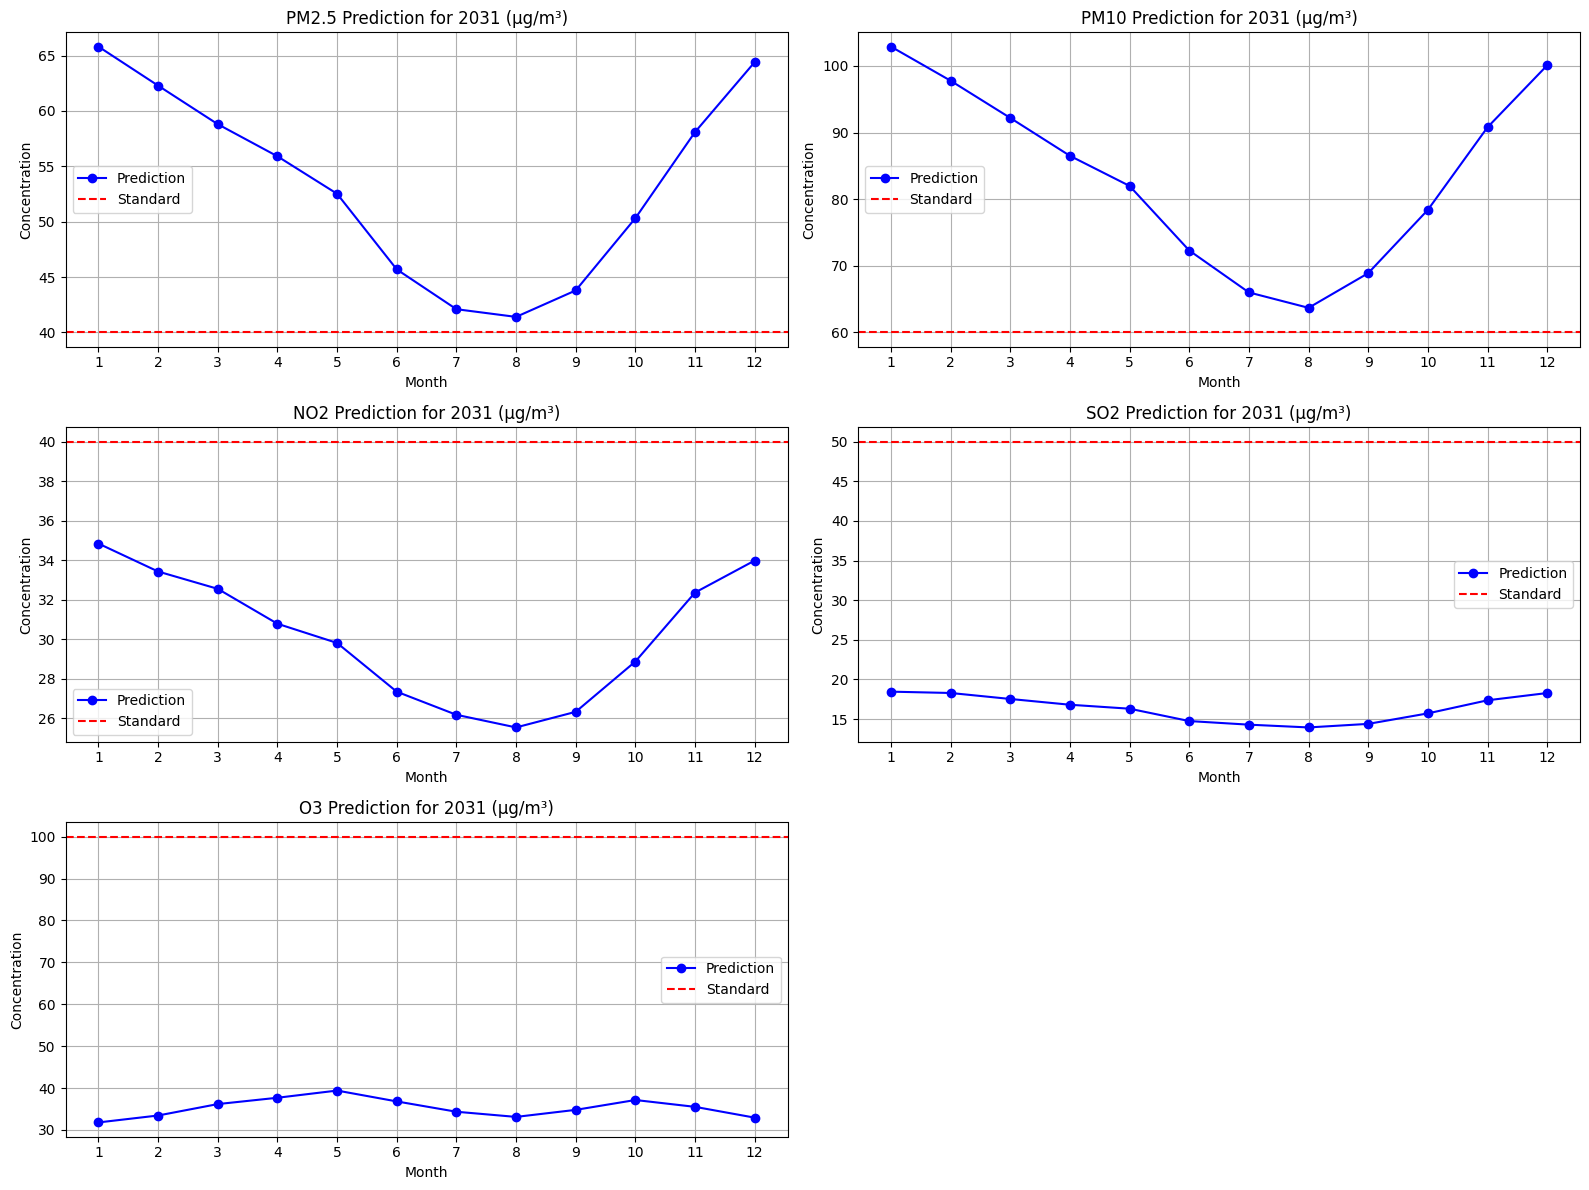


Predicted Days Exceeding Standards in 2031:
PM2.5: 12 days
PM10 : 12 days
NO2  :  0 days
SO2  :  0 days
O3   :  0 days

General Recommendations for Pune:
1. Monitor pollution hotspots during winter months
2. Focus on transportation emissions reduction
3. Maintain and increase urban green cover
4. Implement seasonal pollution control measures


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load air quality data
air_quality = pd.read_csv('air_pollution_data.csv')

# Load population data from separate CSV and group by year
population_data = pd.read_csv('population_data.csv')
population_data = population_data.groupby('Year')['totalpop'].sum().reset_index()
population_data.rename(columns={'totalpop': 'Total_Population'}, inplace=True)

# Enhanced dataset with Pune-specific features
pune_data = pd.DataFrame({
    'Year': [1991, 2001, 2011, 2021, 2031],
    'Tree_Count': [None, None, 4.0, 5.14, 5.58],    # In millions (2011,2022,2023)
    'Vehicle_Count': [0.3, 0.8, 1.8, 3.5, 5.2]      # In millions
})

# Merge with population data from CSV
pune_data = pune_data.merge(population_data, on='Year', how='left')

# Interpolate missing years (1991-2023)
all_years = pd.DataFrame({'Year': range(air_quality['Year'].min(), 2024)})
pune_features = all_years.merge(pune_data, on='Year', how='left')
pune_features = pune_features.interpolate()

# For 2031, we'll need to estimate population if not available
if 2031 not in population_data['Year'].values:
    # Simple linear projection based on last two available years
    last_years = population_data.tail(2)
    slope = (last_years['Total_Population'].iloc[1] - last_years['Total_Population'].iloc[0]) / (last_years['Year'].iloc[1] - last_years['Year'].iloc[0])
    pune_features.loc[pune_features['Year'] == 2031, 'Total_Population'] = last_years['Total_Population'].iloc[1] + slope * (2031 - last_years['Year'].iloc[1])

# Merge with air quality data
full_data = air_quality.merge(pune_features, on='Year')

# Feature engineering
full_data['Population_Density'] = full_data['Total_Population'] * 1000000 / 331  # Pune area in km²
full_data['Trees_Per_Capita'] = full_data['Tree_Count'] * 1000000 / (full_data['Total_Population'] * 1000000)
full_data['Vehicles_Per_Capita'] = full_data['Vehicle_Count'] / full_data['Total_Population']
full_data['Month_Sin'] = np.sin(2 * np.pi * full_data['Month']/12)
full_data['Month_Cos'] = np.cos(2 * np.pi * full_data['Month']/12)

# Handle remaining missing values if any
full_data = full_data.dropna()

# Prepare 2031 prediction data
future_data = pune_features[pune_features['Year'] == 2031].copy()
future_data = pd.concat([future_data]*12, ignore_index=True)
future_data['Month'] = range(1, 13)
future_data['Month_Sin'] = np.sin(2 * np.pi * future_data['Month']/12)
future_data['Month_Cos'] = np.cos(2 * np.pi * future_data['Month']/12)
future_data['Population_Density'] = future_data['Total_Population'] * 1000000 / 331
future_data['Trees_Per_Capita'] = future_data['Tree_Count'] * 1000000 / (future_data['Total_Population'] * 1000000)
future_data['Vehicles_Per_Capita'] = future_data['Vehicle_Count'] / future_data['Total_Population']

# Train models for each pollutant (rest of the code remains the same)
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3']
features = ['Year', 'Month', 'Total_Population', 'Tree_Count', 'Vehicle_Count',
            'Population_Density', 'Trees_Per_Capita', 'Vehicles_Per_Capita',
            'Month_Sin', 'Month_Cos']

predictions = pd.DataFrame({'Year': [2031]*12, 'Month': range(1,13)})

for pollutant in pollutants:
    print(f"\n=== Training models for {pollutant} ===")

    X = full_data[features]
    y = full_data[pollutant]

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Define models with imputation pipeline
    models = {
        'Random Forest': make_pipeline(
            SimpleImputer(strategy='median'),
            RandomForestRegressor(n_estimators=200, random_state=42)
        ),
        'Gradient Boosting': make_pipeline(
            SimpleImputer(strategy='median'),
            GradientBoostingRegressor(n_estimators=200, random_state=42)
        ),
        'XGBoost': make_pipeline(
            SimpleImputer(strategy='median'),
            XGBRegressor(n_estimators=200, random_state=42)
        ),
        'LightGBM': make_pipeline(
            SimpleImputer(strategy='median'),
            LGBMRegressor(n_estimators=200, random_state=42, verbose=-1)
        )
    }

    # Evaluate models
    results = {}
    for name, model in models.items():
        scores = []
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores.append(r2_score(y_test, y_pred))

        avg_r2 = np.mean(scores)
        results[name] = {'model': model, 'r2': avg_r2}
        print(f"{name:20} Average R2: {avg_r2:.2f}")

    # Select best model
    best_model_name = max(results.items(), key=lambda x: x[1]['r2'])[0]
    best_model = results[best_model_name]['model']
    print(f"\nBest model for {pollutant}: {best_model_name} (R2: {results[best_model_name]['r2']:.2f})")

    # Train final model on all data
    best_model.fit(X, y)

    # Make predictions
    predictions[pollutant] = best_model.predict(future_data[features])

# Format and display results
print("\n2031 Air Quality Predictions for Pune:")
print(predictions.round(3))
predictions.round(3).to_csv('Predictions_Air_Pollution_2031.csv', index = False)

# Plotting with comparison to standards
plt.figure(figsize=(16, 12))
standards = {'PM2.5': 40, 'PM10': 60, 'NO2': 40, 'SO2': 50, 'O3': 100}  # Indian standards

for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)

    # Plot predictions
    plt.plot(predictions['Month'], predictions[pollutant], 'b-', marker='o', label='Prediction')

    # Add standard line
    plt.axhline(y=standards[pollutant], color='r', linestyle='--', label='Standard')

    plt.title(f'{pollutant} Prediction for 2031 (μg/m³)')
    plt.xlabel('Month')
    plt.ylabel('Concentration')
    plt.xticks(range(1,13))
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate exceedance days
print("\nPredicted Days Exceeding Standards in 2031:")
for pollutant in pollutants:
    exceed_days = sum(predictions[pollutant] > standards[pollutant])
    print(f"{pollutant:5}: {exceed_days:2} days")

# General recommendations
print("\nGeneral Recommendations for Pune:")
print("1. Monitor pollution hotspots during winter months")
print("2. Focus on transportation emissions reduction")
print("3. Maintain and increase urban green cover")
print("4. Implement seasonal pollution control measures")